<a href="https://colab.research.google.com/github/twishi03/liver/blob/master/TILs_IHC%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/L3dZ6fgmllI


**RGB to Haematoxylin-Eosin-DAB (HED) color space conversion followed by nuclei segmentation and analysis**

separate the immunohistochemical (IHC) staining from the hematoxylin counterstaining. The IHC staining expression of the FHL2 protein is here revealed with diaminobenzidine (DAB) which gives a brown color.

A. C. Ruifrok and D. A. Johnston, “Quantification of histochemical staining by color deconvolution,” Analytical and quantitative cytology and histology / the International Academy of Cytology [and] American Society of Cytology, vol. 23, no. 4, pp. 291-9, Aug. 2001. PMID: 11531144

https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py

Try WSI datasets from here
https://zenodo.org/record/1485967#.Yd31lv7MKbh
https://www.wouterbulten.nl/blog/tech/peso-dataset-whole-slide-image-prosate-cancer/



In [1]:

import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

In [2]:
# Separate the individual stains from the IHC image
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    ihc_hed = rgb2hed(ihc_rgb)

    # Create an RGB image for each of the separated stains
    #Convert them to ubyte for easy saving to drive as an image
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    #Optional fun exercise of combining H and DAB stains into a single image with fluorescence look

    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

# Cast the two channels into an RGB image, as the blue and green channels
#Convert to ubyte for easy saving as image to local drive
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

In [3]:
ihc_rgb =io.imread("/content/cd8.jpg")
H,E,D,HD = color_separate(ihc_rgb)
#plt.imsave('images/H_img.jpg', H)
#plt.imsave('images/DAB_img.jpg', D)

Text(0.5, 1.0, 'D image')

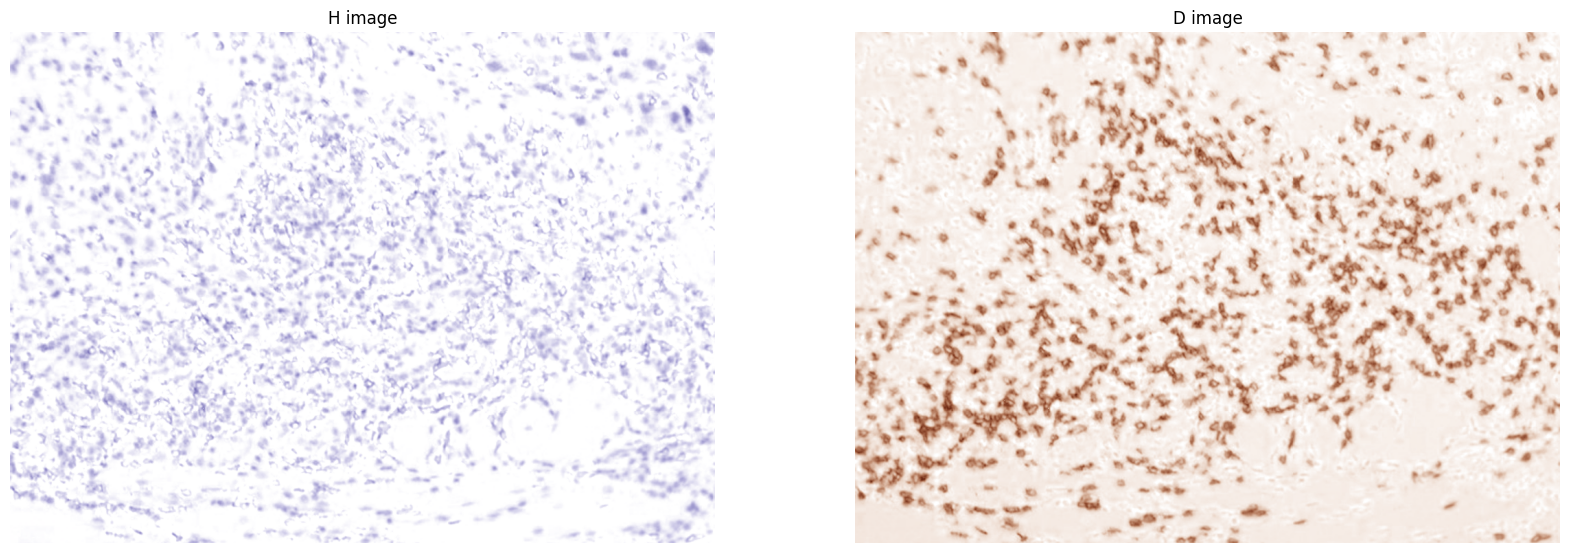

In [4]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H)
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D)
plt.axis("off")
plt.title("D image")

In [5]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 8.5 MB/s eta 0:00:00


In [6]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [7]:
# prints a list of available models
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [8]:
# Define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Text(0.5, 1.0, 'D image')

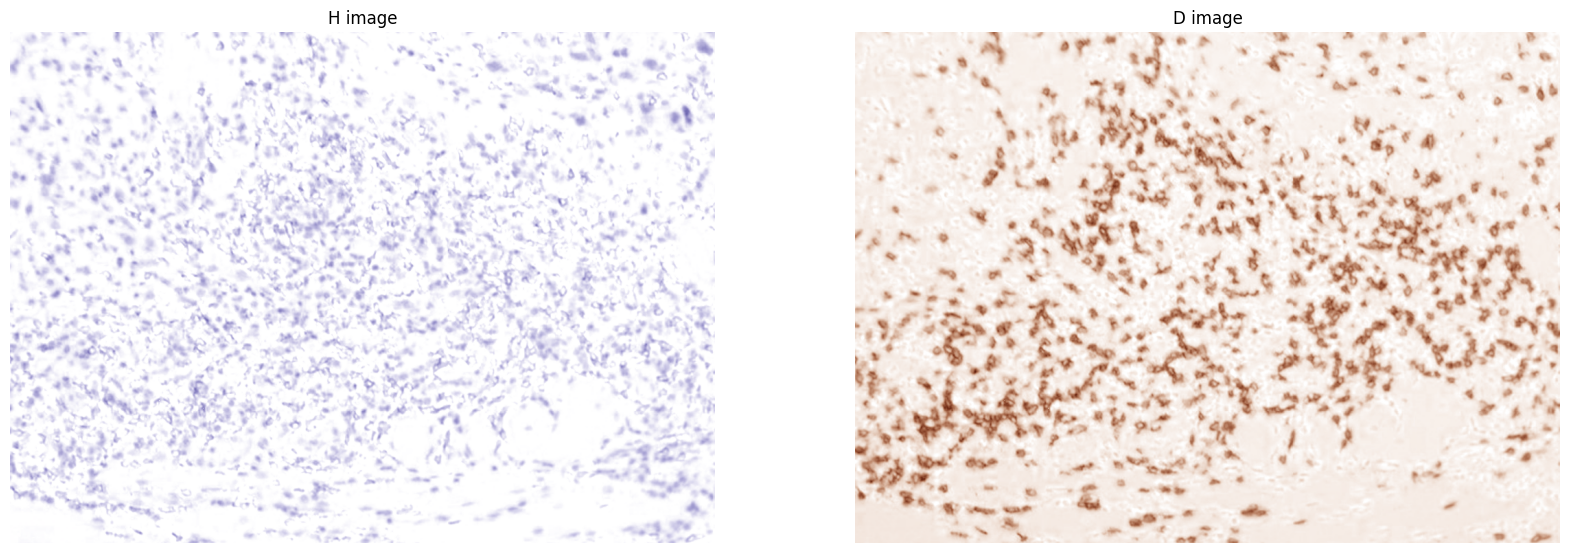

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H)
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D)
plt.axis("off")
plt.title("D image")

Text(0.5, 1.0, 'D image')

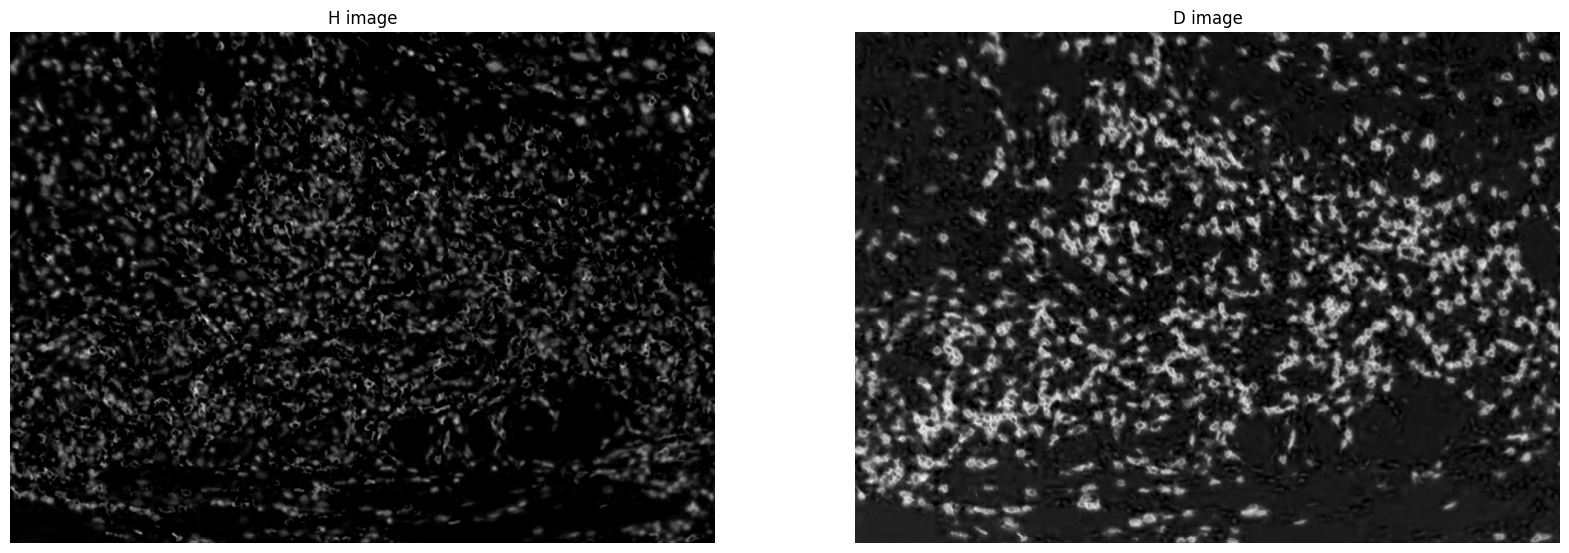

In [10]:
H_img = np.invert(H[:,:,2])
D_img = np.invert(D[:,:,2])
#plt.imshow(D_img, cmap='gray')

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H_img, cmap='gray')
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D_img, cmap='gray')
plt.axis("off")
plt.title("D image")

In [11]:
D_labels, D_details = model.predict_instances(normalize(D_img))
H_labels, H_details = model.predict_instances(normalize(H_img))


Text(0.5, 1.0, 'prediction + input overlay')

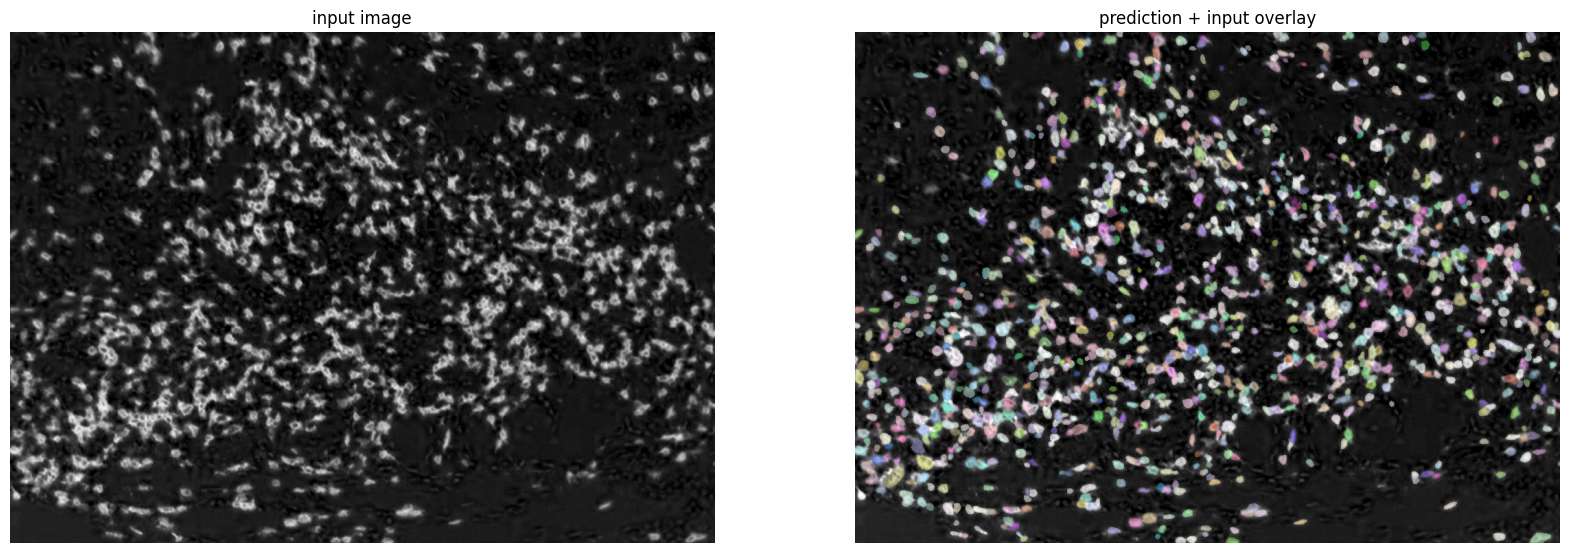

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(D_img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(D_labels, img=D_img))
plt.axis("off")
plt.title("prediction + input overlay")

Text(0.5, 1.0, 'prediction + input overlay')

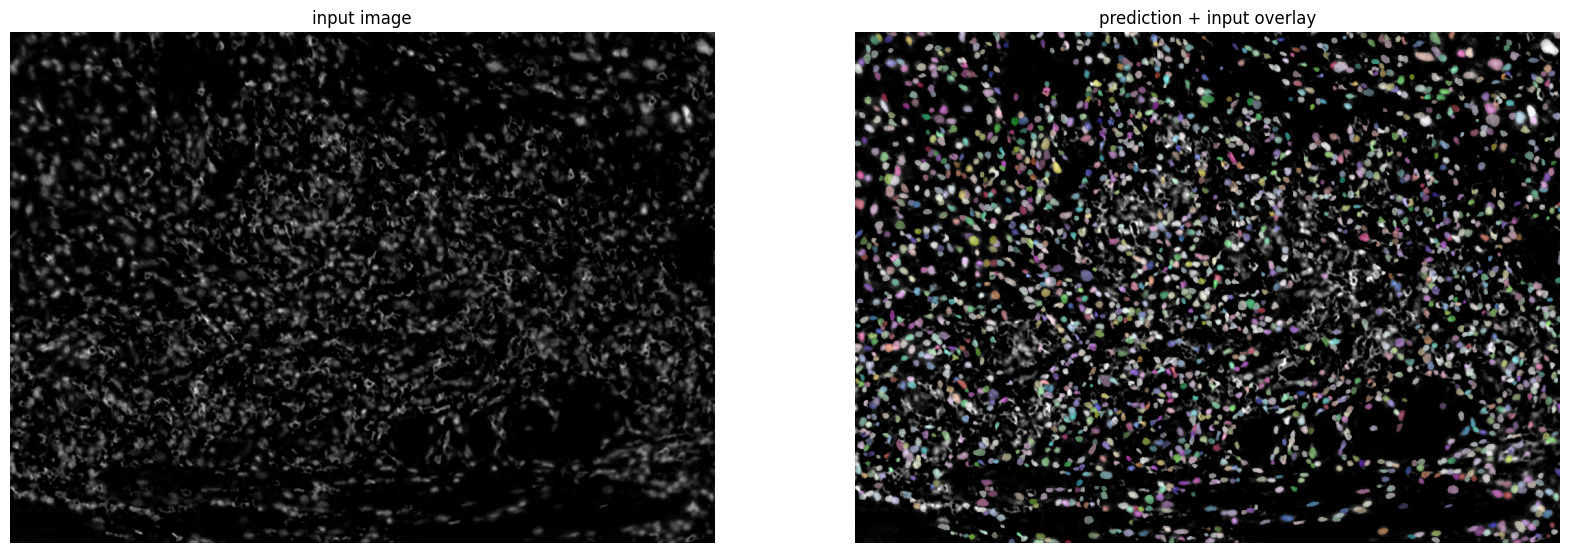

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H_img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(H_labels, img=H_img))
plt.axis("off")
plt.title("prediction + input overlay")

In [14]:
from skimage.measure import regionprops_table
import pandas as pd

In [15]:
D_props = regionprops_table(D_labels, D_img,
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])

D_analysis_results = pd.DataFrame(D_props)
print(D_analysis_results.head())

   label  area  equivalent_diameter  mean_intensity  solidity
0      1   149            13.773623      117.771812  0.937107
1      2   142            13.446190      134.323944  0.946667
2      3   145            13.587484      129.317241  0.960265
3      4   139            13.303394      121.129496  0.932886
4      5   176            14.969641      104.409091  0.936170


In [16]:
H_props = regionprops_table(H_labels, H_img,
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])

H_analysis_results = pd.DataFrame(H_props)
print(H_analysis_results.head())

   label  area  equivalent_diameter  mean_intensity  solidity
0      1    97            11.113246       26.113402  0.950980
1      2   104            11.507255       33.115385  0.945455
2      3    70             9.440697       25.885714  0.933333
3      4   133            13.013103       15.947368  0.963768
4      5   113            11.994835       40.884956  0.949580


In [17]:
D_mean_analysis_results = D_analysis_results.mean(axis=0)
D_mean_analysis_results

label                  547.500000
area                   116.757770
equivalent_diameter     11.873620
mean_intensity         108.925294
solidity                 0.932717
dtype: float64

In [18]:
H_mean_analysis_results = H_analysis_results.mean(axis=0)
H_mean_analysis_results

label                  1123.500000
area                     66.295191
equivalent_diameter       9.021171
mean_intensity           17.738223
solidity                  0.929648
dtype: float64

In [19]:
D_total_area = D_analysis_results["area"].sum()
H_total_area = H_analysis_results["area"].sum()
positivity = D_total_area / (D_total_area + H_total_area)
print("The DAB positivity is: ", positivity)

The DAB positivity is:  0.4617433991729084
